## 快速开始

In [1]:
import torch
from torch import nn

使用 FashionMNIST 数据集来训练神经网络，预测输入图像是否属于以下类别之一：T 恤/上衣、裤子、套头衫、连衣裙、外套、凉鞋、衬衫、运动鞋、包或靴子。  
### 处理数据
PyTorch 提供特定领域的库，例如TorchText、 TorchVision和TorchAudio，所有这些库都包含数据集。对于本教程，我们将使用 TorchVision 数据集。
该torchvision.datasets模块包含Dataset许多真实世界视觉数据的对象，如 CIFAR、COCO。在本教程中，我们使用 FashionMNIST 数据集。每个 TorchVision 都Dataset包含两个参数：transform和 target_transform分别修改样本和标签。

In [2]:
from torchvision import datasets
from torchvision.transforms import ToTensor
#下载训练集
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    #转换为张量
    transform=ToTensor(),
)
#下载测试集
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

### 迭代和可视化数据集
我们可以Datasets像列表一样手动索引：training_data[index]。我们用来matplotlib可视化训练数据中的一些样本。

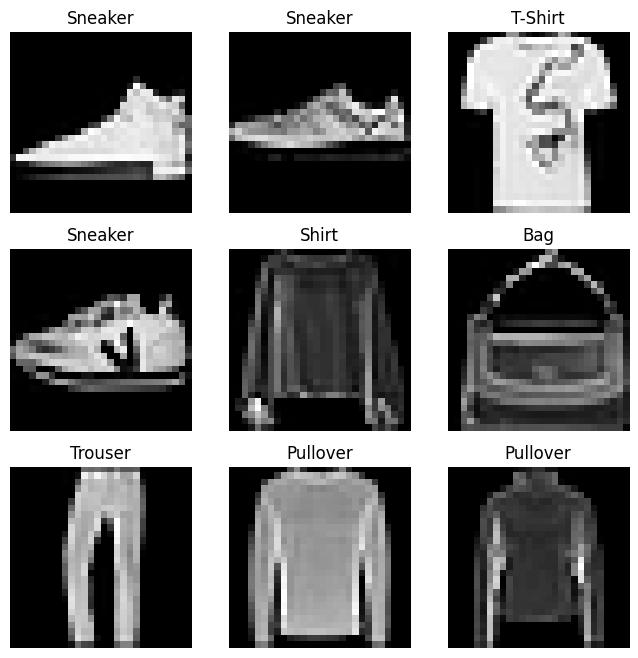

In [18]:
import matplotlib.pyplot as plt
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    #随机在训练集里挑选一个样本
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

我们将Dataset作为参数传递给DataLoader。这在我们的数据集上包装了一个可迭代对象，并支持自动批处理、采样、混洗和多进程数据加载。这里我们定义了一个批大小为 64，即 dataloader 中的每个元素 iterable 将返回一批 64 个特征和标签。

In [4]:
from torch.utils.data import DataLoader
batch_size = 64
# 创建数据加载器
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)
for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


### 创建模型
为了在 PyTorch 中定义神经网络，我们创建了一个继承自nn.Module的类。我们在函数中定义网络的层__init__，并指定数据将如何通过函数中的网络forward。为了加速神经网络中的操作，我们将其移至 GPU 或 MPS（如果可用）。

In [5]:
# 获取用于训练的设备
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


创建神经网络类

In [6]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


### 优化模型参数
要训​​练模型，我们需要一个损失函数 和一个优化器。

In [7]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

在单个训练循环中，模型对训练数据集（分批输入）进行预测，并反向传播预测误差以调整模型的参数。

In [8]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # 计算预测误差
        pred = model(X)
        loss = loss_fn(pred, y)

        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"误差: {loss:>7f}  [{current:>5d}/{size:>5d}]")

我们还根据测试数据集检查模型的性能，以确保它正在学习。

In [9]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"测试: \n 准确性: {(100*correct):>0.1f}%, 平均误差: {test_loss:>8f} \n")

训练过程进行了几次迭代（epochs）。在每个时期，模型学习参数以做出更好的预测。我们在每个时期打印模型的准确性和损失；我们希望看到每个时期的准确性都在提高，损失在减少。

In [10]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
误差: 2.306944  [   64/60000]
误差: 2.290527  [ 6464/60000]
误差: 2.269251  [12864/60000]
误差: 2.262347  [19264/60000]
误差: 2.250318  [25664/60000]
误差: 2.220046  [32064/60000]
误差: 2.224709  [38464/60000]
误差: 2.192987  [44864/60000]
误差: 2.191884  [51264/60000]
误差: 2.154834  [57664/60000]
测试: 
 准确性: 49.5%, 平均误差: 2.148621 

Epoch 2
-------------------------------
误差: 2.169488  [   64/60000]
误差: 2.150617  [ 6464/60000]
误差: 2.083027  [12864/60000]
误差: 2.097646  [19264/60000]
误差: 2.051631  [25664/60000]
误差: 1.991609  [32064/60000]
误差: 2.013783  [38464/60000]
误差: 1.934778  [44864/60000]
误差: 1.939253  [51264/60000]
误差: 1.862138  [57664/60000]
测试: 
 准确性: 59.7%, 平均误差: 1.859730 

Epoch 3
-------------------------------
误差: 1.904346  [   64/60000]
误差: 1.864312  [ 6464/60000]
误差: 1.733906  [12864/60000]
误差: 1.778202  [19264/60000]
误差: 1.683097  [25664/60000]
误差: 1.631226  [32064/60000]
误差: 1.653045  [38464/60000]
误差: 1.560204  [44864/60000]
误差: 1.583360  [51264/60000

### 保存模型
保存模型的常用方法是序列化内部状态字典（包含模型参数）。

In [11]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth
